#Predictive Lead Scoring Portal for Banking Sales

Cohort Members:

1.
2.



##Importing necessary libraries & dataset (Alif)

In [ ]:
# Basi libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

#Preprocessing & Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTETomek


#Modeling
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight


import joblib


##Data Loading

Sumber dataset -> https://archive.ics.uci.edu/dataset/222/bank+marketing

In [ ]:
uploaded = files.upload()

df = pd.read_csv('bank-additional-full.csv', sep=';') # Pakai final bank-additional-full.csv dengan 21 fitur

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:10], "...")



Saving bank-additional-full.csv to bank-additional-full.csv
Shape: (41188, 21)
Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week'] ...


##Data Exploration (Shafa)

###Info & summary

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


##Penjelasan perkolom

age = Usia nasabah dalam tahun, digunakan untuk mengetahui pengaruh umur terhadap kemungkinan berlangganan deposito.

job = Jenis pekerjaan nasabah, seperti “admin.”, “blue-collar”, “technician”; membantu mengenali kelompok pekerjaan dengan minat deposito tertentu.

marital = Status pernikahan nasabah (“single”, “married”, “divorced”); dapat memengaruhi keputusan finansial.

education = Tingkat pendidikan terakhir, menggambarkan tingkat pengetahuan dan pengambilan keputusan finansial nasabah.

default = Menunjukkan apakah nasabah memiliki kredit macet sebelumnya (“yes”/“no”/“unknown”); penting untuk menilai risiko kredit.

housing = Status apakah nasabah memiliki pinjaman rumah (“yes”/“no”/“unknown”); merefleksikan beban finansial saat ini.

loan = Status apakah nasabah memiliki pinjaman pribadi lainnya (“yes”/“no”/“unknown”); mempengaruhi kemampuan berinvestasi.

contact = Jenis komunikasi terakhir yang digunakan saat kampanye (“cellular” atau “telephone”); bisa berpengaruh terhadap keberhasilan kontak.

month = Bulan terakhir dilakukan kontak dengan nasabah; dapat membantu melihat pola musiman dari keberhasilan kampanye.

day_of_week = Hari dalam seminggu saat kontak dilakukan; digunakan untuk mencari waktu paling efektif dalam melakukan promosi.

duration = Lama waktu panggilan terakhir dalam detik; durasi lebih lama biasanya menunjukkan ketertarikan lebih tinggi.

campaign = Jumlah total kontak yang dilakukan selama kampanye saat ini untuk nasabah tersebut; terlalu banyak kontak bisa menurunkan efektivitas.

pdays = Jumlah hari sejak terakhir kali nasabah dihubungi dari kampanye sebelumnya (999 berarti belum pernah dihubungi); menunjukkan tingkat ketertarikan sebelumnya.

previous = Jumlah kontak yang dilakukan sebelum kampanye saat ini; dapat menunjukkan pengalaman atau ketertarikan historis nasabah.

poutcome = Hasil dari kampanye sebelumnya (“success”, “failure”, “nonexistent”); fitur penting untuk mengukur efek riwayat komunikasi.

emp.var.rate = Ini adalah tingkat perubahan lapangan kerja (employment) di suatu periode (biasanya per kuartal).
Kalau nilainya negatif, artinya jumlah pekerjaan menurun — kondisi ekonomi sedang lesu.
Kalau positif, artinya ekonomi membaik dan lapangan kerja bertambah.
Hal ini bisa memengaruhi minat masyarakat dalam berinvestasi, termasuk membuka deposito.

cons.price.idx = Ini adalah indeks harga konsumen (CPI), indikator inflasi bulanan.
Kalau angkanya naik, berarti harga barang dan jasa meningkat.
Inflasi tinggi biasanya membuat masyarakat lebih berhati-hati dalam menyimpan uang, termasuk di deposito.

cons.conf.idx = Ini adalah indeks kepercayaan konsumen — seberapa optimis atau pesimis masyarakat terhadap ekonomi.
Jika nilainya tinggi (positif), artinya masyarakat percaya kondisi ekonomi sedang baik, jadi lebih mungkin untuk berinvestasi.
Kalau nilainya rendah (negatif), masyarakat cenderung menunda investasi seperti deposito.

euribor3m = Ini adalah suku bunga acuan Eropa untuk pinjaman 3 bulan.
Nilai ini sering digunakan untuk mengukur kondisi ekonomi global.
Jika Euribor tinggi, bunga pinjaman juga tinggi — orang mungkin lebih tertarik menyimpan uang di bank (deposito).

nr.employed = Menunjukkan jumlah total tenaga kerja di negara tersebut dalam satu periode (biasanya per kuartal).
Kalau nilainya tinggi, artinya banyak orang bekerja → ekonomi stabil → masyarakat punya penghasilan tetap → lebih besar peluang buka deposito.
Kalau turun, artinya ekonomi sedang melemah dan daya beli menurun.

Euribor tinggi → bunga deposito tinggi → lebih banyak orang mau menabung.Euribor rendah → bunga deposito kecil → orang cenderung tidak tertarik.

y = Variabel target, menunjukkan apakah nasabah berlangganan deposito berjangka (“yes” = 1, “no” = 0).

###Target variable 'y'
Menunjukkan bahwa label “no” jauh lebih banyak dibanding “yes”, menandakan dataset tidak seimbang (imbalanced)

y
no     36548
yes     4640
Name: count, dtype: int64


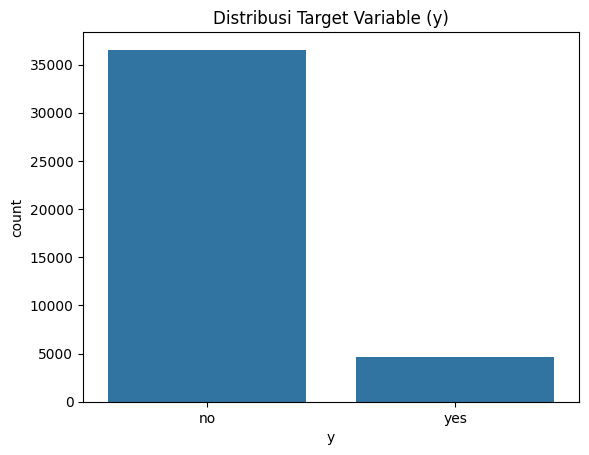

In [ ]:
df_target = df['y']
df_target.value_counts()
print(df_target.value_counts())

# Visualisasi
sns.countplot(x='y', data=df)
plt.title("Distribusi Target Variable (y)")
plt.show()

###Numerical features
Histogram tiap fitur numerik (seperti age, duration, campaign) memperlihatkan pola distribusi, termasuk outlier dan skewness.


In [ ]:
numerical_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]

df_num = df[numerical_cols]
df_num.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


###Histogram numerik

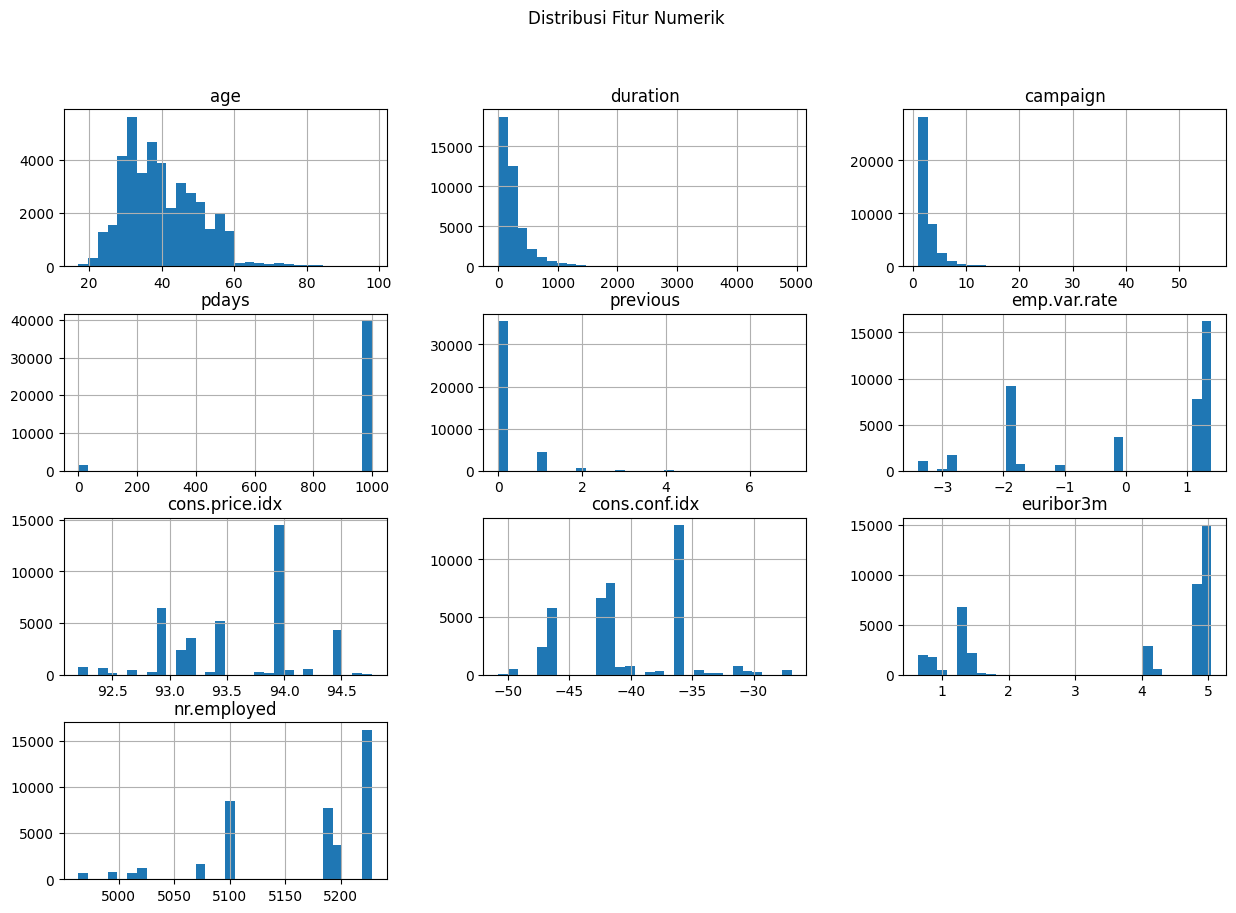

In [ ]:
df_num.hist(bins=30, figsize=(15,10))
plt.suptitle("Distribusi Fitur Numerik")
plt.show()

###Korelasi numerik dengan target
Menunjukkan hubungan antar fitur numerik; terlihat beberapa fitur ekonomi seperti euribor3m dan nr.employed saling berkorelasi kuat.

In [ ]:
df['y_encoded'] = df['y'].map({'yes':1, 'no':0})
corr = df_num.corrwith(df['y_encoded'])
print("Korelasi Numerik dengan Target:\n", corr)

Korelasi Numerik dengan Target:
 age               0.030399
duration          0.405274
campaign         -0.066357
pdays            -0.324914
previous          0.230181
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
dtype: float64


###Heatmap korelasi numerik
Menunjukkan hubungan antar fitur numerik; terlihat beberapa fitur ekonomi seperti euribor3m dan nr.employed saling berkorelasi kuat.

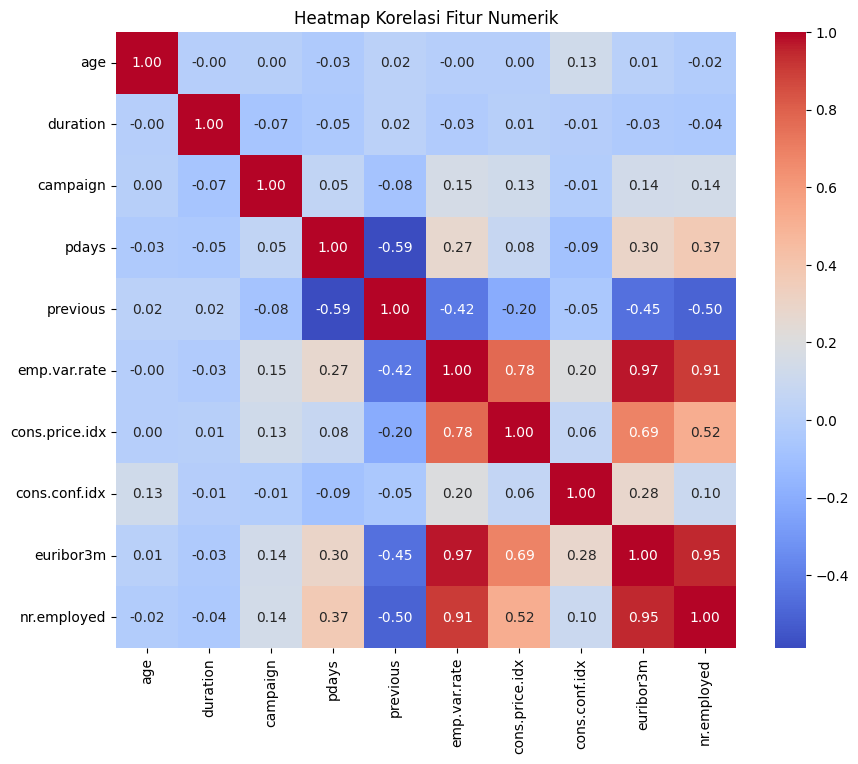

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df_num.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

### Categorical features
Menggunakan countplot untuk melihat frekuensi tiap kategori seperti job, marital, dan education, serta mendeteksi nilai “unknown”.

In [ ]:
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'day_of_week', 'poutcome'
]

df_cat = df[categorical_cols]

for col in categorical_cols:
    print(f"\n=== {col} ===")
    print(df_cat[col].value_counts())


=== job ===
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

=== marital ===
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

=== education ===
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

=== default ===
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

=== housing ===
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

=== loan ===
loan
no         33950
yes         6248
unknown      9

###Bar plots kategori

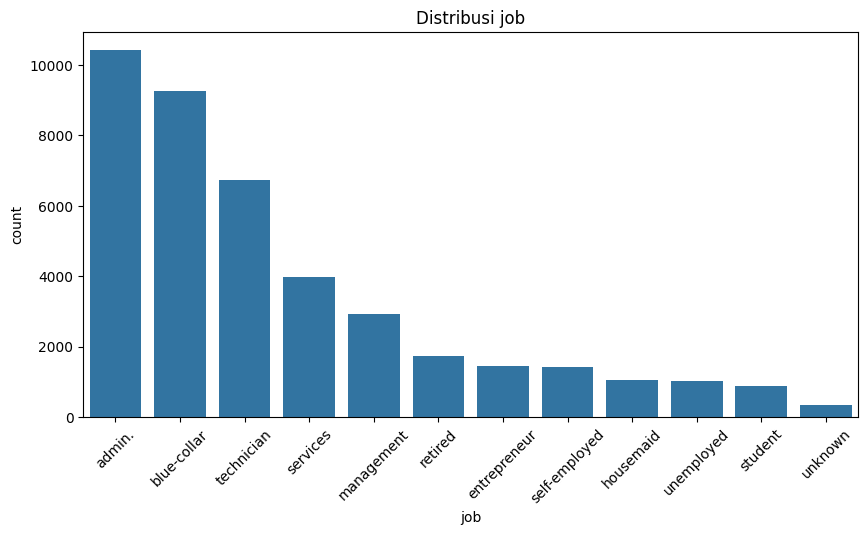

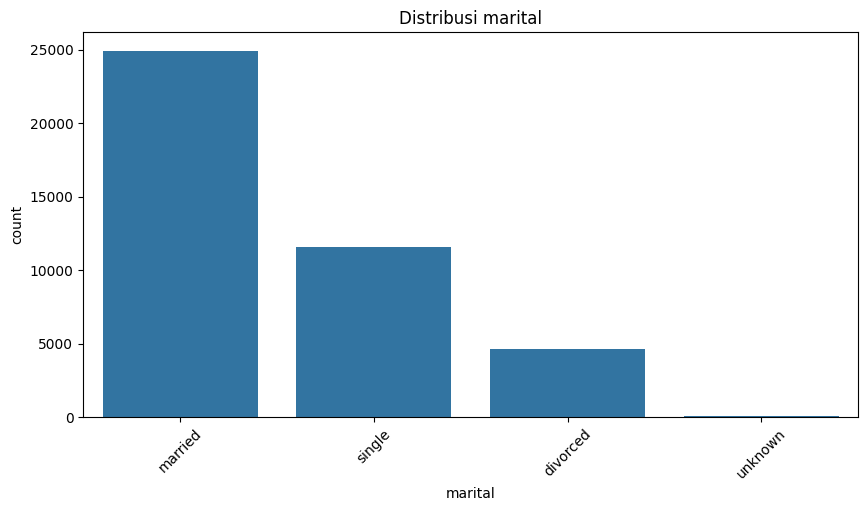

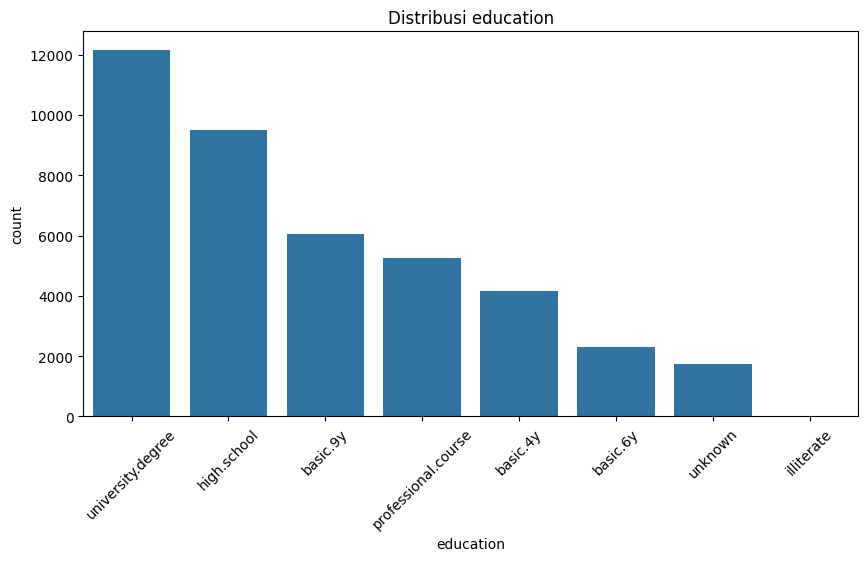

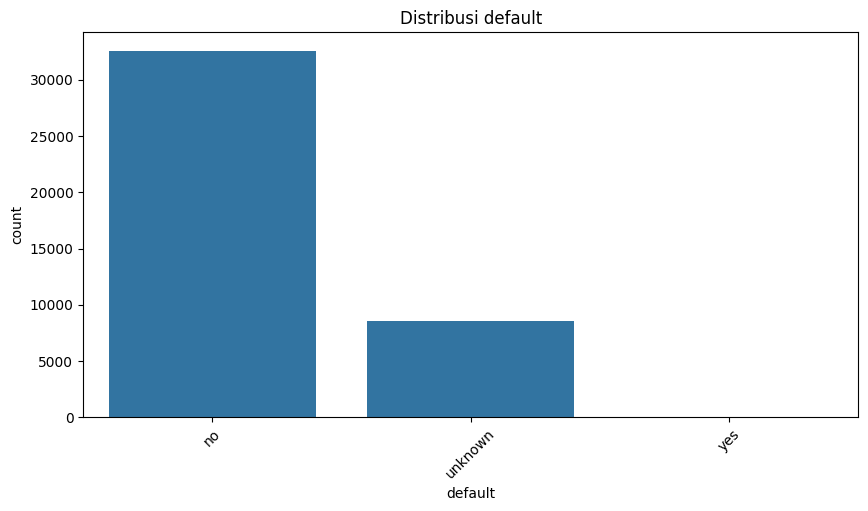

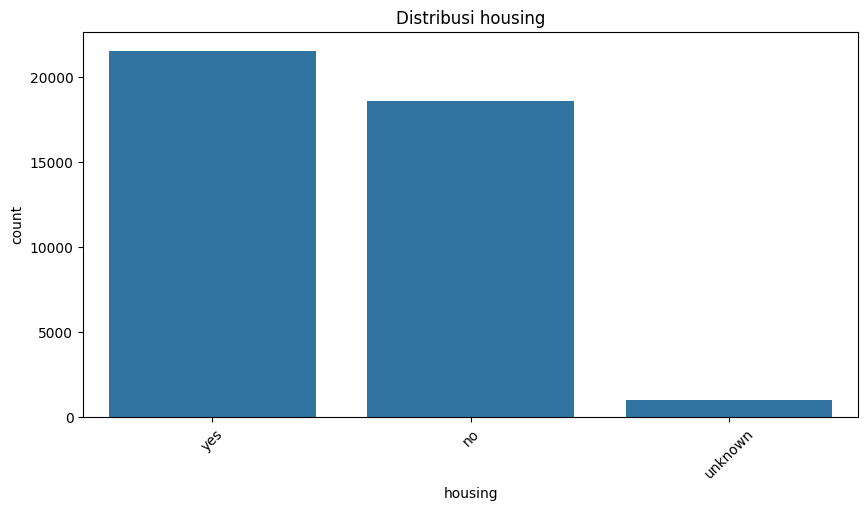

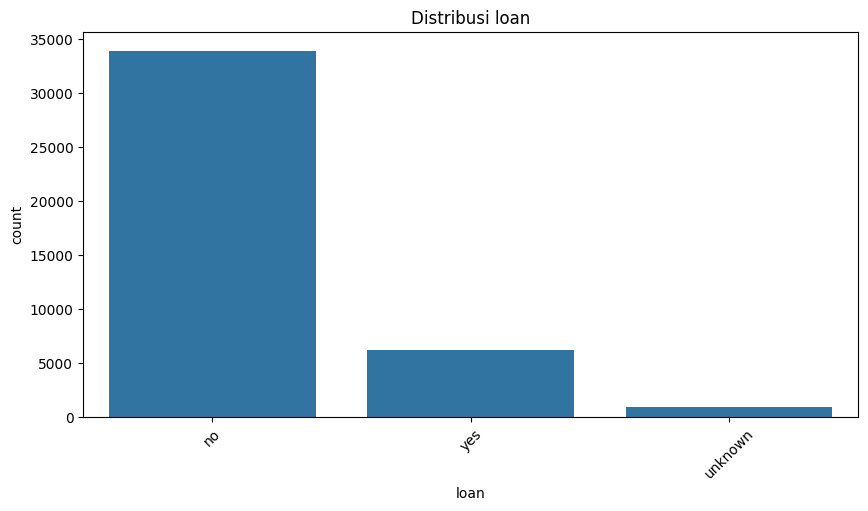

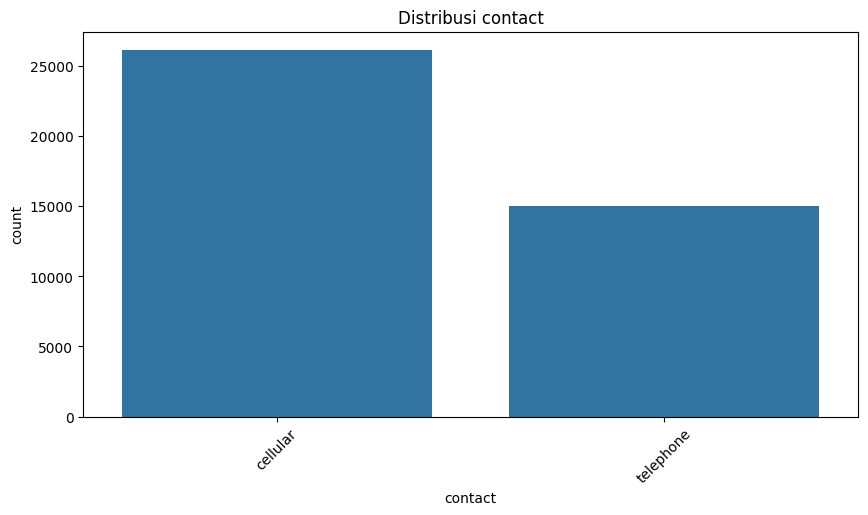

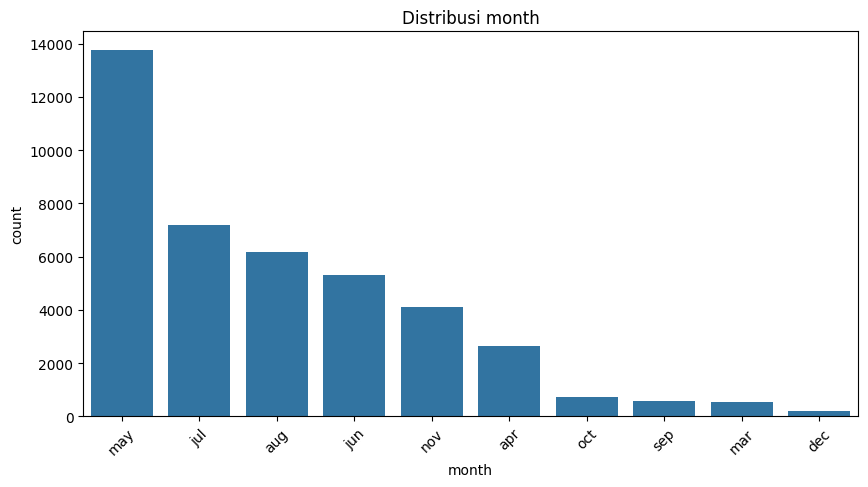

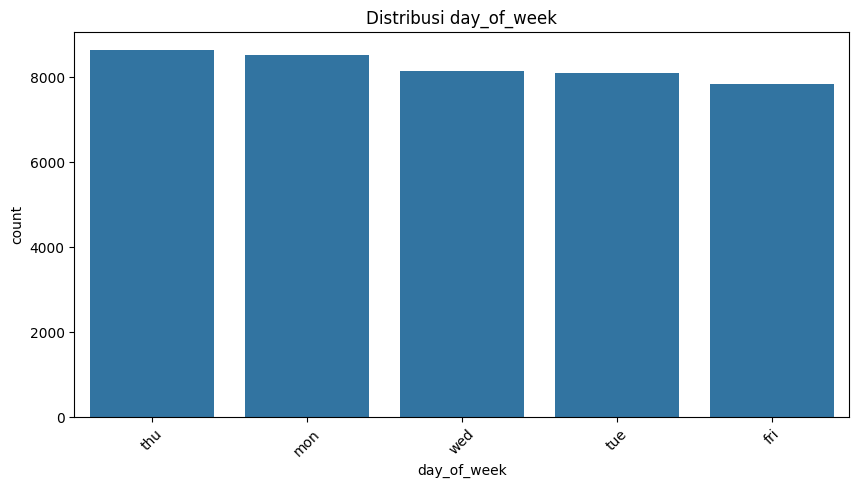

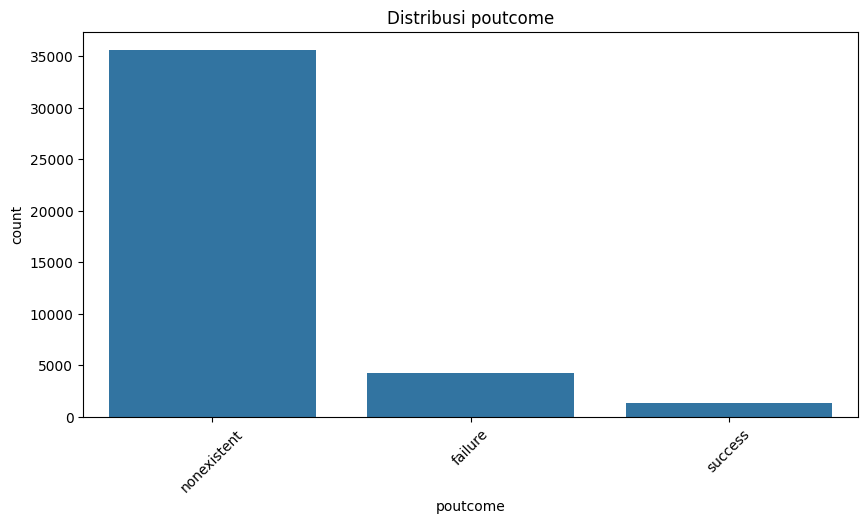

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribusi {col}")
    plt.xticks(rotation=45)
    plt.show()

###Missing / unknown values

In [ ]:
df_unknown = df_cat.apply(lambda x: (x=="unknown").sum())
print("Jumlah 'unknown' di tiap fitur kategorikal:\n", df_unknown)

Jumlah 'unknown' di tiap fitur kategorikal:
 job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
poutcome          0
dtype: int64


###Target vs Categorical


=== job vs y ===
y                no   yes
job                      
admin.         9070  1352
blue-collar    8616   638
entrepreneur   1332   124
housemaid       954   106
management     2596   328
retired        1286   434
self-employed  1272   149
services       3646   323
student         600   275
technician     6013   730
unemployed      870   144
unknown         293    37


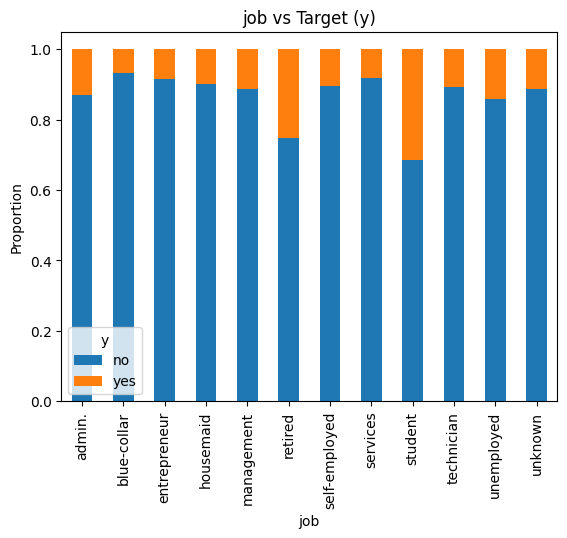


=== marital vs y ===
y            no   yes
marital              
divorced   4136   476
married   22396  2532
single     9948  1620
unknown      68    12


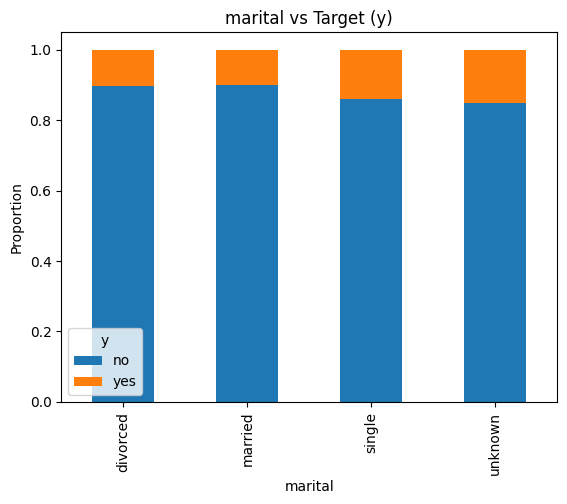


=== education vs y ===
y                       no   yes
education                       
basic.4y              3748   428
basic.6y              2104   188
basic.9y              5572   473
high.school           8484  1031
illiterate              14     4
professional.course   4648   595
university.degree    10498  1670
unknown               1480   251


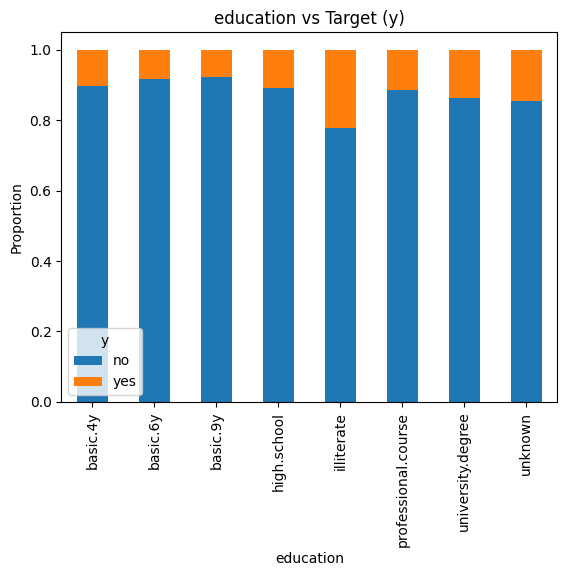


=== default vs y ===
y           no   yes
default             
no       28391  4197
unknown   8154   443
yes          3     0


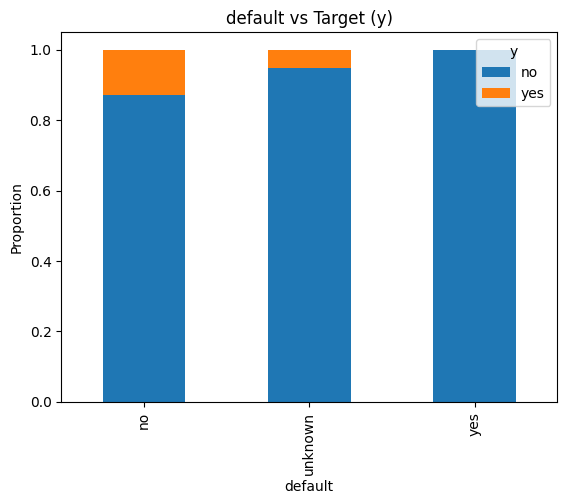


=== housing vs y ===
y           no   yes
housing             
no       16596  2026
unknown    883   107
yes      19069  2507


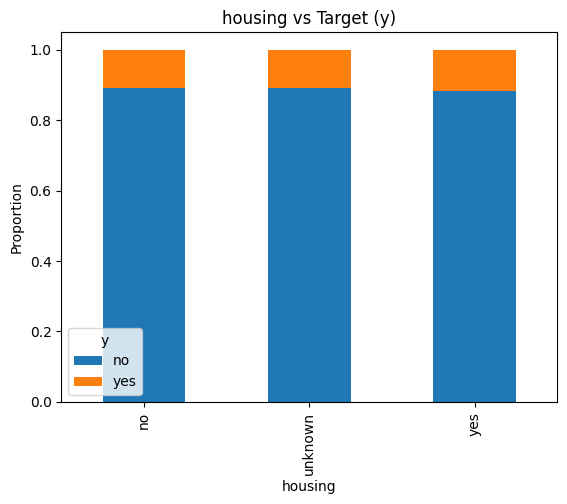


=== loan vs y ===
y           no   yes
loan                
no       30100  3850
unknown    883   107
yes       5565   683


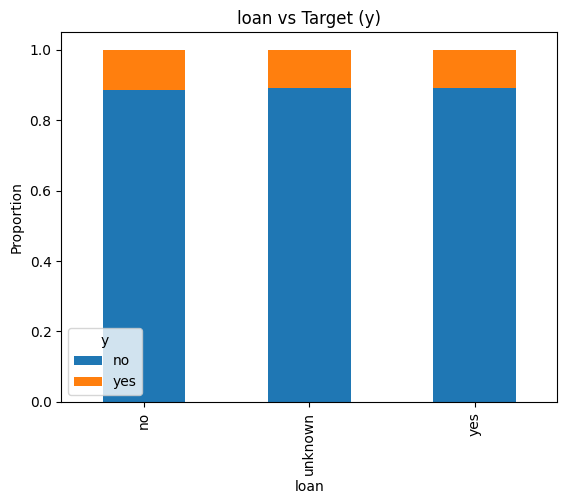


=== contact vs y ===
y             no   yes
contact               
cellular   22291  3853
telephone  14257   787


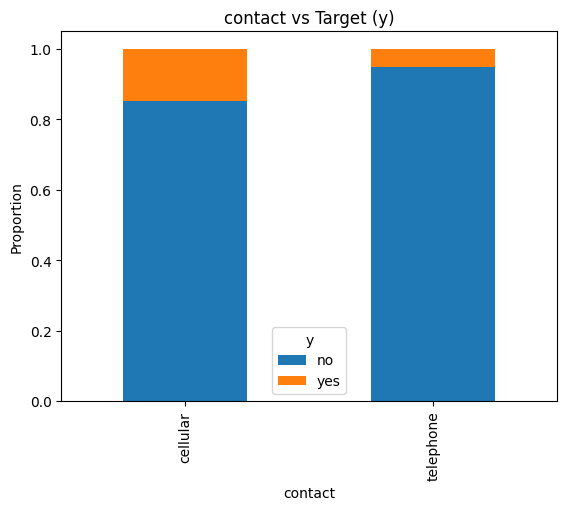


=== month vs y ===
y         no  yes
month            
apr     2093  539
aug     5523  655
dec       93   89
jul     6525  649
jun     4759  559
mar      270  276
may    12883  886
nov     3685  416
oct      403  315
sep      314  256


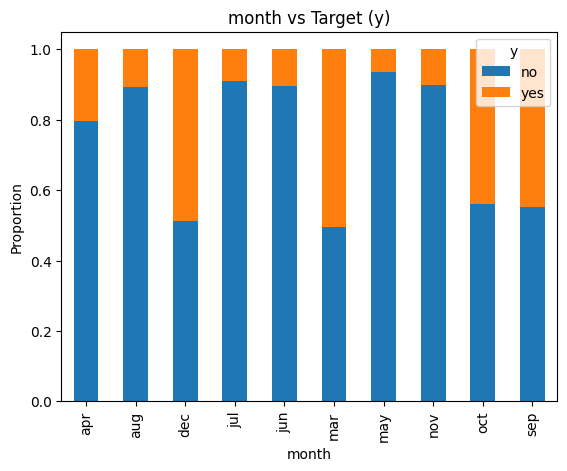


=== day_of_week vs y ===
y              no   yes
day_of_week            
fri          6981   846
mon          7667   847
thu          7578  1045
tue          7137   953
wed          7185   949


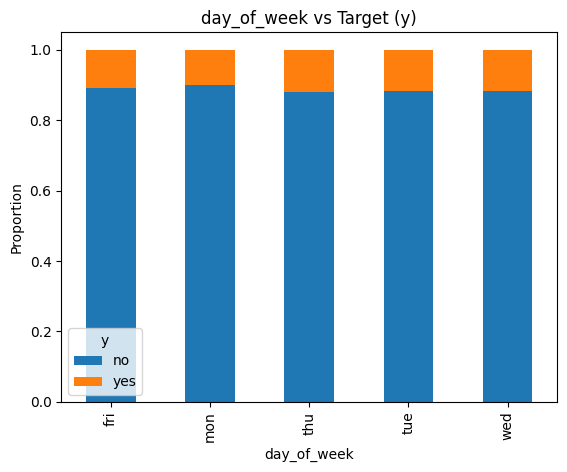


=== poutcome vs y ===
y               no   yes
poutcome                
failure       3647   605
nonexistent  32422  3141
success        479   894


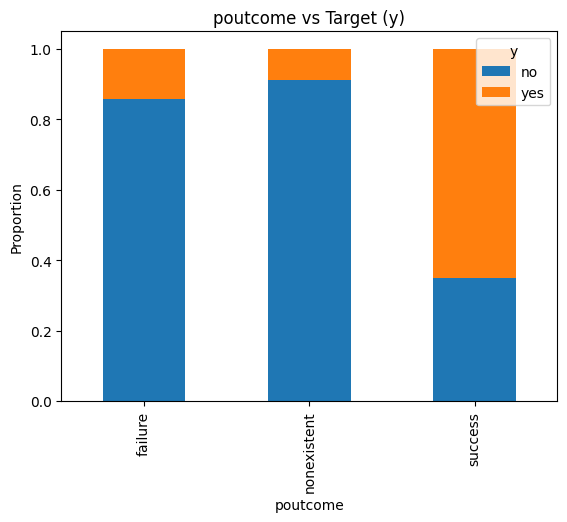

In [ ]:
for col in categorical_cols:
    ct = pd.crosstab(df[col], df['y'])
    print(f"\n=== {col} vs y ===")
    print(ct)
    ct.div(ct.sum(1), axis=0).plot(kind='bar', stacked=True)
    plt.title(f"{col} vs Target (y)")
    plt.ylabel("Proportion")
    plt.show()

###Target vs Numerical
Membandingkan nilai fitur numerik berdasarkan kelas target; misalnya duration lebih tinggi pada nasabah yang menjawab “yes”.

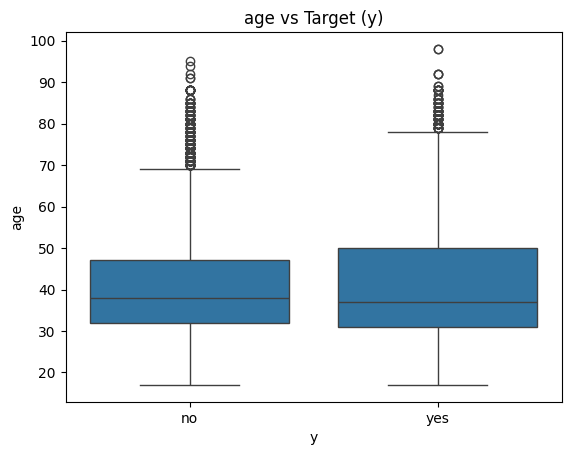

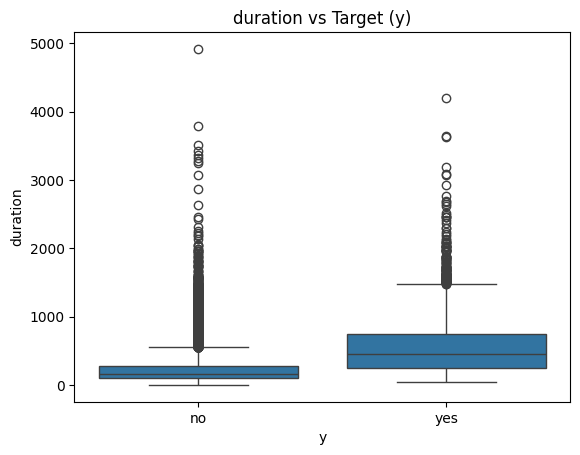

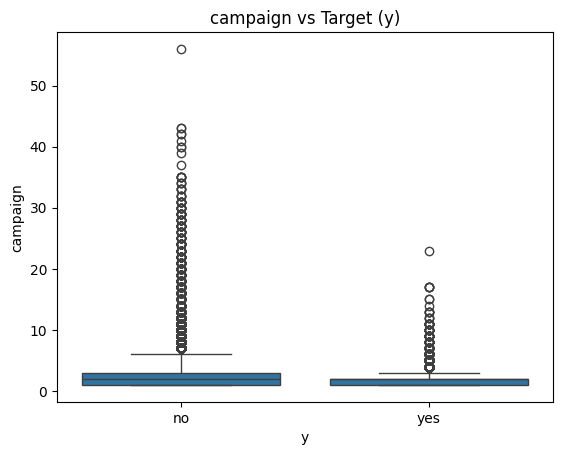

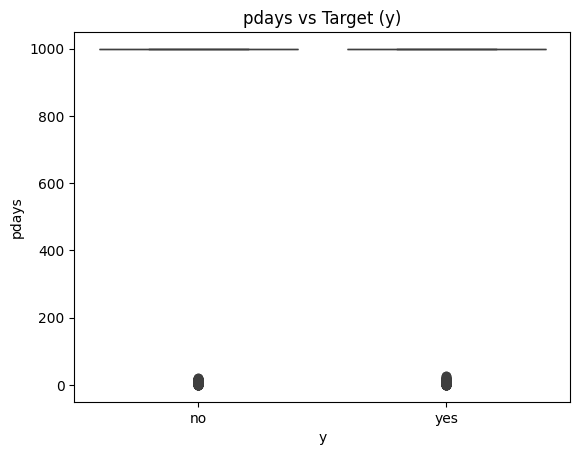

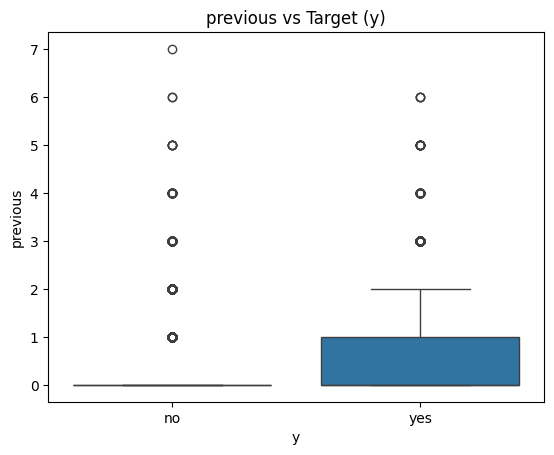

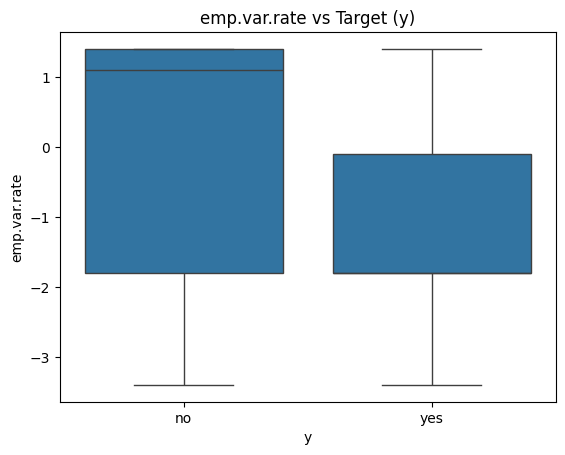

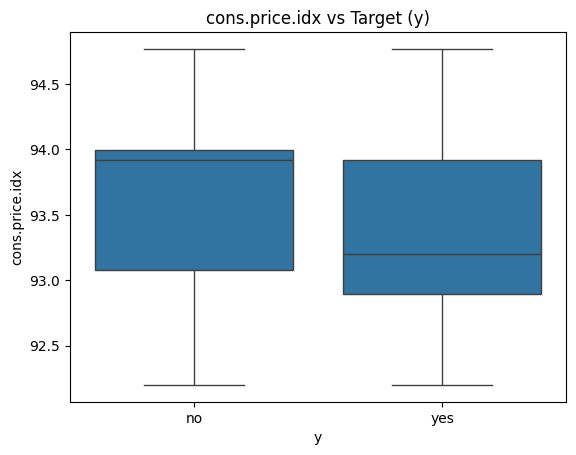

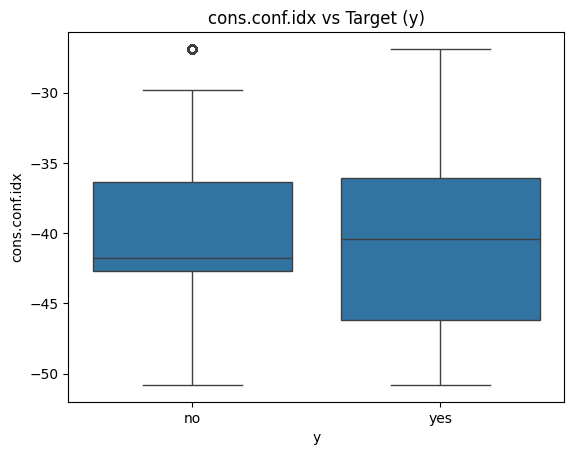

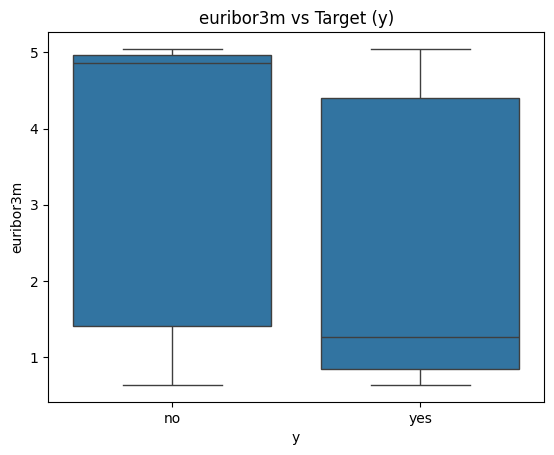

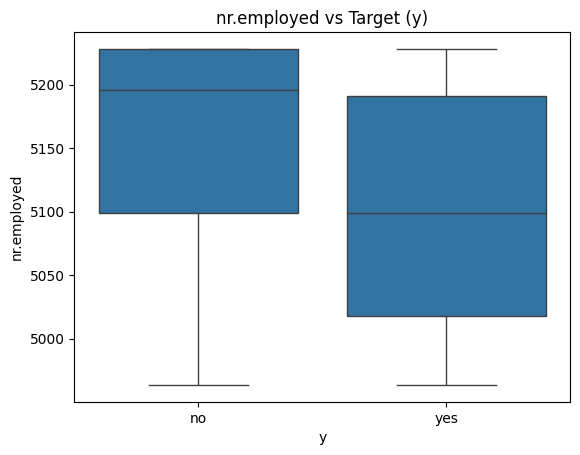

In [ ]:
for col in numerical_cols:
    sns.boxplot(x='y', y=col, data=df)
    plt.title(f"{col} vs Target (y)")
    plt.show()

###Pairplot beberapa numerik penting

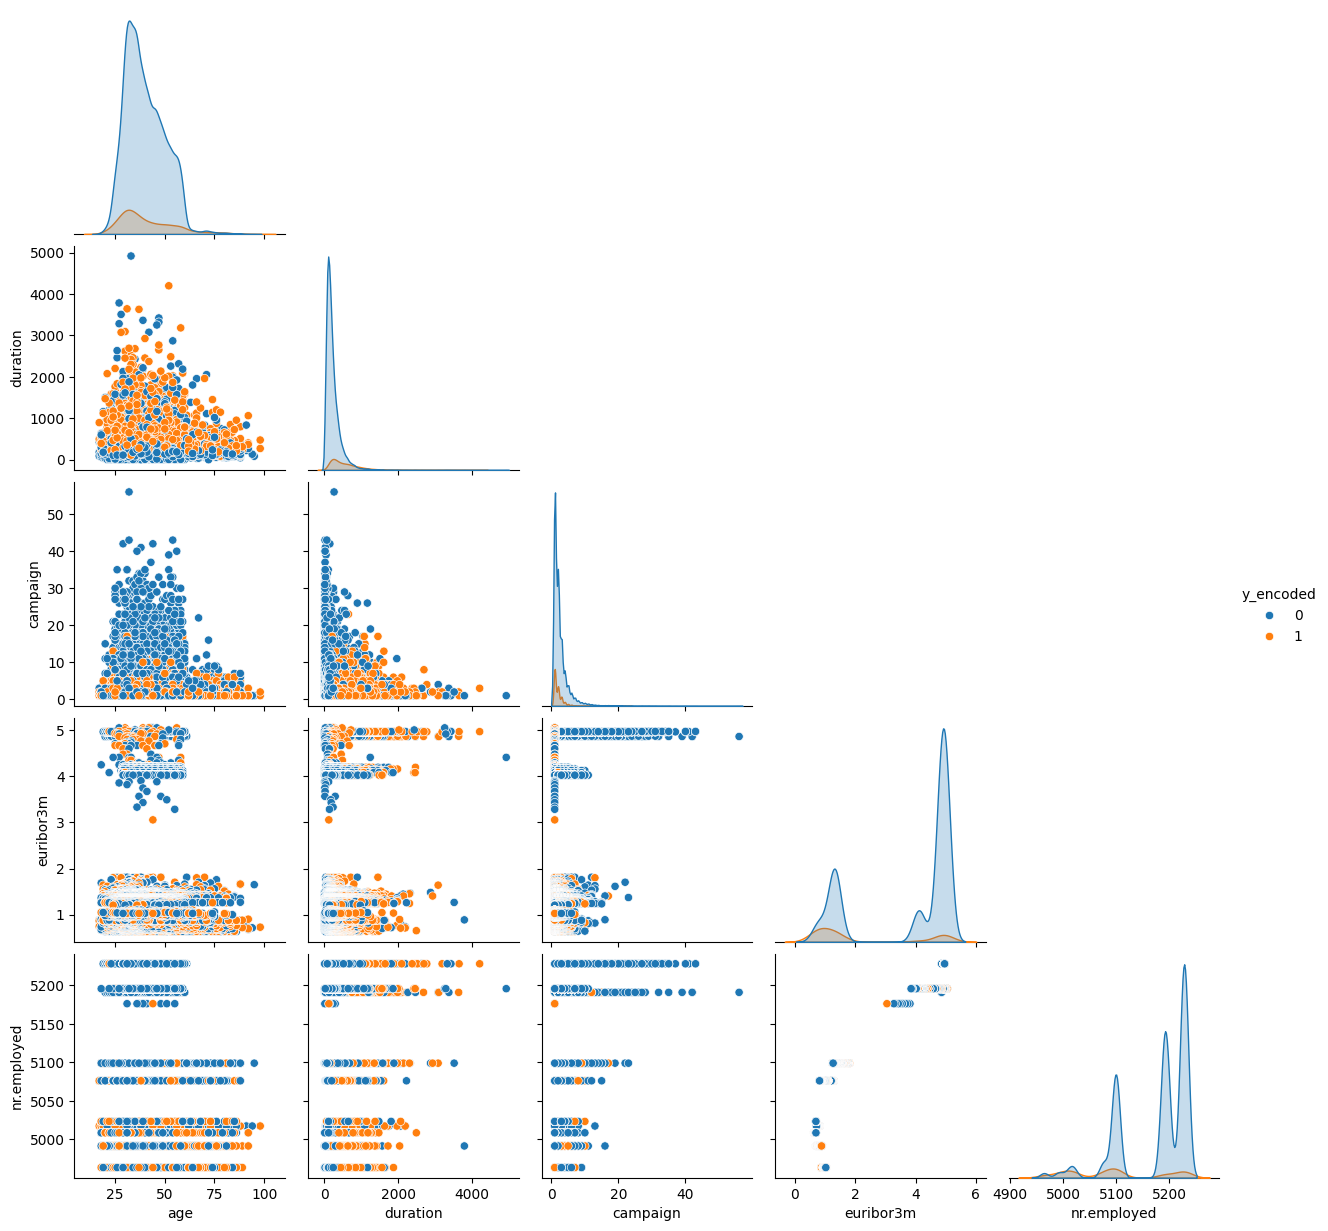

In [ ]:
important_num = ['age', 'duration', 'campaign', 'euribor3m', 'nr.employed', 'y_encoded']
sns.pairplot(df[important_num], hue='y_encoded', corner=True)
plt.show()

##Data Preprocessing (Shafa)

In [27]:
# Load dataset
df = pd.read_csv("bank-additional-full.csv", sep=';')

# Drop fitur target leakage
df.drop(columns=['duration'], inplace=True)

# Ganti 999 pdays dengan NaN
df['pdays'] = df['pdays'].replace(999, np.nan)

# Fitur numerik (high + medium importance)
num_features = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]

# Fitur kategori untuk one-hot encoding (high + medium importance)
cat_features_onehot = [
    'job', 'marital', 'education', 'poutcome'
]

# Fitur kategori untuk label encoding (medium importance)
cat_features_label = ['housing', 'loan']

# Target
target = 'y'
df[target] = df[target].map({'no': 0, 'yes': 1})

# Split train-test
X = df.drop(columns=[target])
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipeline
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_onehot_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

cat_label_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ordinal', OrdinalEncoder(categories=[['no','yes','unknown']]*len(cat_features_label)))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat_onehot', cat_onehot_transformer, cat_features_onehot),
    ('cat_label', cat_label_transformer, cat_features_label)
])

# Transform train & test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Ambil nama fitur hasil one-hot
onehot_features = preprocessor.named_transformers_['cat_onehot']['onehot'].get_feature_names_out(cat_features_onehot)

# Semua fitur akhir
all_features = num_features + list(onehot_features) + cat_features_label

# Buat DataFrame preprocessed
df_train_final = pd.DataFrame(X_train_processed, columns=all_features)
df_train_final[target] = y_train

df_test_final = pd.DataFrame(X_test_processed, columns=all_features)
df_test_final[target] = y_test

# Simpan ke CSV & preprocessor
df_train_final.to_csv("bank_marketing_train_preprocessed.csv", index=False)
df_test_final.to_csv("bank_marketing_test_preprocessed.csv", index=False)
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

#Modeling(Baseline Modeling) Alif

### Data splitting

###XGboost and Catboost

In [31]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import numpy as np

X_train = X_train_processed
X_test = X_test_processed

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos

param_dist_xgb = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 2, 5],
    'min_child_weight': [1, 5, 10, 20],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [0.5, 1, 2, 5]
}

xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight
)

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    scoring='f1',
    cv=5,
    n_iter=50,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_xgb.fit(X_train, y_train)
best_xgb = rand_xgb.best_estimator_

param_dist_cat = {
    'iterations': [200, 400, 600],
    'depth': [5, 7, 9],
    'learning_rate': [0.03, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat = CatBoostClassifier(
    eval_metric='F1',
    random_seed=42,
    verbose=0,
    class_weights=[1, scale_pos_weight]
)

rand_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist_cat,
    scoring='f1',
    cv=5,
    n_iter=40,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_cat.fit(X_train, y_train)
best_cat = rand_cat.best_estimator_

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_xgb = cross_val_predict(best_xgb, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
ths = np.linspace(0.05, 0.95, 91)
best_th_xgb, best_f1_xgb = 0.5, 0
for t in ths:
    f = f1_score(y_train, (oof_xgb >= t).astype(int))
    if f > best_f1_xgb:
        best_f1_xgb, best_th_xgb = f, t

oof_cat = cross_val_predict(best_cat, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
best_th_cat, best_f1_cat = 0.5, 0
for t in ths:
    f = f1_score(y_train, (oof_cat >= t).astype(int))
    if f > best_f1_cat:
        best_f1_cat, best_th_cat = f, t


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:04:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:29:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:29:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:29:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:29:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:29:14] WARNING: /w

###Model Evaluation and saving (Alif & Shafa)

In [32]:

def evaluate_model(name, model, X_test, y_test, threshold):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\n{name} (threshold={threshold:.3f})")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"ROC AUC   : {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return f1, roc_auc

print("\n=== EVALUATION WITH OPTIMAL THRESHOLD ===")

f1_xgb, auc_xgb = evaluate_model("XGBoost", best_xgb, X_test, y_test, best_th_xgb)
f1_cat, auc_cat = evaluate_model("CatBoost", best_cat, X_test, y_test, best_th_cat)

joblib.dump(best_xgb, "best_bank_model_xgb.pkl")
joblib.dump(best_cat, "best_bank_model_cat.pkl")

print("\nModels saved:")
print("best_bank_model_xgb.pkl")
print("best_bank_model_cat.pkl")

summary = pd.DataFrame({
    "Model": ["XGBoost", "CatBoost"],
    "F1 Score": [f1_xgb, f1_cat],
    "ROC AUC": [auc_xgb, auc_cat],
    "Threshold": [best_th_xgb, best_th_cat]
})

print("\nSummary:")
print(summary)



=== EVALUATION WITH OPTIMAL THRESHOLD ===

XGBoost (threshold=0.640)
Accuracy  : 0.8761
Precision : 0.4613
Recall    : 0.5981
F1 Score  : 0.5209
ROC AUC   : 0.8092
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7310
           1       0.46      0.60      0.52       928

    accuracy                           0.88      8238
   macro avg       0.70      0.75      0.72      8238
weighted avg       0.89      0.88      0.88      8238

[[6662  648]
 [ 373  555]]

CatBoost (threshold=0.610)
Accuracy  : 0.8731
Precision : 0.4531
Recall    : 0.6088
F1 Score  : 0.5195
ROC AUC   : 0.8052
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7310
           1       0.45      0.61      0.52       928

    accuracy                           0.87      8238
   macro avg       0.70      0.76      0.72      8238
weighted avg       0.89      0.87      0.88      8238

[[6628  682]
 [ 363  565]]

Mod